# Import library

In [11]:
!which python

/home/zhanggenqi/miniconda3/envs/ENV_DLCV_HW1/bin/python


packages allowed for use during inference

In [21]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import VGG16_Weights


import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


from P2_train_val_CustomDataset import P2_CustomDataset
from P2_train_val_CustomTransform import CustomTransform




packages during training

In [22]:
from torchsummary import summary
from thop import profile
#conda install ipykernel
#conda install notebook

# Hyperparameters

In [23]:
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset

custom dataset

problem: 不知道為什麼在另一個file建P2_CustomDataset class，更新class後這個file不會同步更新

先計算此training dataset的mean & std

In [24]:
# 計算normalization需要的mean & std
def get_mean_std(dataset):
    # Get mean and std by sample ratio
    dataloader = DataLoader(dataset, batch_size=int(len(dataset)), shuffle=True, num_workers=2)

    image = next(iter(dataloader))[0]     # get the first batch's all image data([0]: image, [1]: mask)
    mean = np.mean(image.numpy(), axis=(0,2,3)) 
    std = np.std(image.numpy(), axis=(0,2,3))
    return mean, std

#train_dataset_meanstd = P2_CustomDataset(data_dir='../hw1_data/p2_data/train', transform=transforms.ToTensor()) #transforms.ToTensor(): divide pixel value by 255


#train_mean, train_std = get_mean_std(train_dataset_meanstd)
#print(train_mean, train_std)

In [25]:
train_mean = [0.4085139,  0.37851316, 0.28088593]
train_std = [0.14234419, 0.10848381, 0.09824713]

建train transform和val transform

val transform和test transform一樣

In [26]:
# data augmentation & normalization
# (如果image翻轉或平移，mask也應翻轉或平移)
transform_train = CustomTransform(p=0.5, mean=train_mean, std=train_std)

transform_val = CustomTransform(p=0, mean=train_mean, std=train_std)

用P2_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [27]:
train_dataset = P2_CustomDataset(data_dir='../hw1_data/p2_data/train', transform=transform_train)
val_dataset = P2_CustomDataset(data_dir='../hw1_data/p2_data/validation', transform=transform_val)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [28]:
# print shape
image_first_batch, mask_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(mask_first_batch): ", type(mask_first_batch))
print("mask_first_batch.shape: ", mask_first_batch.shape)

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([8, 3, 512, 512])
type(mask_first_batch):  <class 'torch.Tensor'>
mask_first_batch.shape:  torch.Size([8, 1, 512, 512])


In [29]:
print(mask_first_batch[7][0][7][500])
print(image_first_batch[1][0][200][100])

tensor(3, dtype=torch.uint8)
tensor(-0.5006)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


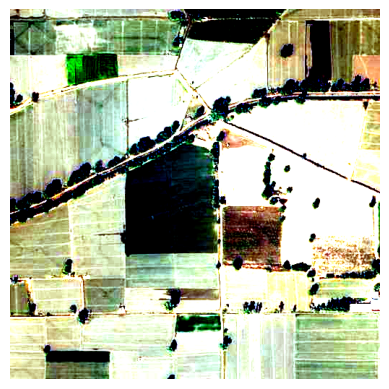

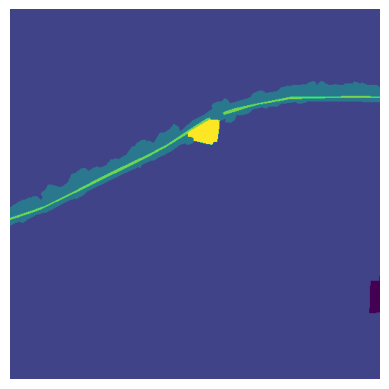

In [33]:
# visualize wo normalization
idx = 2
first_image = image_first_batch[idx]
first_mask = mask_first_batch[idx]

# Convert the tensor to numpy array
image_np = first_image.numpy()
mask_np = first_mask.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))
mask_np = np.transpose(mask_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
plt.imshow(mask_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [34]:
print(torch.cuda.is_available())

True


# Build Model

problem: 不知道為什麼在另一個file建VGG16_FCN32s class，更新class後這個file不會同步更新

In [35]:
# 建立model
class VGG16_FCN32s(nn.Module):
    def __init__(self, n_classes=7):
        super(VGG16_FCN32s, self).__init__()

        # Load the pretrained VGG16 model
        #vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        # self.features's shape should be 512*16*16 if input image size is 3*512*512 (H/32, W/32)
        self.features = models.vgg16(weights=VGG16_Weights.DEFAULT).features
        


        # fc6
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=3, padding=1)  #let its ofmap's shape same as ifmap
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()
        
        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1, padding=0) #let its ofmap's shape same as ifmap
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # score
        self.score = nn.Conv2d(4096, n_classes, kernel_size=7, padding=3) #let its ofmap's shape same as ifmap
        # ofmap should be 7*16*16

        # Upsampling: 7*16*16 to 7*512*512
        self.upsample = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=32, stride=32, padding=0, bias=False)

    def forward(self, x):
        # x: 3*512*512
        
        # VGG16 features
        x = self.features(x)
        # x: 512*16*16
        
        # Forward pass through fully convolutional layers
        x = self.relu6(self.fc6(x))
        x = self.drop6(x)
        # x: 4096*16*16

        x = self.relu7(self.fc7(x))
        x = self.drop7(x)
        # x: 4096*16*16

        x = self.score(x)
        # x: 7*16*16

        # Upsample to original image size
        x = self.upsample(x)
        # x: 7*512*512
        
        return x


instance model

並放到device上(gpu?)


In [36]:
net = VGG16_FCN32s(n_classes=7).to(device)

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
grad_para = count_parameters(net)
# print(f'Total params: {grad_para / 1e6}M')
summary(net,(3,512,512))

#Compute MACs & params
input1 = torch.randn(1,3,512,512).to(device) # dummy input也放到device
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

# Training

Loss and Optimizer and epoch_n

In [38]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
# Different base learning rate and update strategy #!!!!!!
schecdular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
# number of epoch
num_epochs = 100


mIoU 計算

In [39]:
def compute_miou(pred, target, num_classes):

    '''pred: model's output. shape is (len(dataset), n_classes, H, W).
    target: The ground truth mask. shape is [len(dataset), H, W] where each pixel is a class label'''

    # model, input image, output, mask(target, label, GT) are moved to GPU during training
    pred = torch.argmax(pred, dim=1).cpu().numpy() 
    target = target.cpu().numpy()
    
    iou_list = []
    for i in range(num_classes - 1): # num_classes - 1: do not inculde unknown class
        intersection = np.sum((pred == i) & (target == i))  # 交集: TP
        union = np.sum((pred == i) | (target == i)) # 聯集: TP + FP + FN
    
        if union == 0:
            #continue  # Skip if union is zero (i.e., no pixels belong to this class in pred or target in this dataset)
            iou = 0
        else:
            iou = intersection / union  # Normal IoU calculation when union is non-zer
        iou_list.append(iou)

    return np.mean(iou_list)

training & validation loop

In [40]:
# Training and Validation Loop
best_miou = 0

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, targets in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        
        images, targets = images.to(device), targets.to(device)# model, input image, output, mask(target, label, GT) are moved to GPU during training

        optimizer.zero_grad()

        outputs = net(images)
        #print(outputs.shape, targets.shape) #outputs:  torch.Size([8, 7, 512, 512]); targets: torch.Size([8, 1, 512, 512])


        # criterion & compute_miou expect targets shape is N*H*W
        if targets.size(1) == 1:
            targets = targets.squeeze(1)  # Remove the channel dimension if it's 1

        loss = criterion(outputs, targets.long())#expect mask is float64


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(trainloader)

    # Validate
    net.eval() #關掉BN & DROPOUT
    val_loss = 0

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(valloader, desc='Validation', unit='batch'):
            images, targets = images.to(device), targets.to(device)

            outputs = net(images)  #(bs, 7, 512, 512)
            
            # criterion & compute_miou expect targets shape is N*H*W
            if targets.size(1) == 1:
                targets = targets.squeeze(1)  # Remove the channel dimension if it's 1
            loss = criterion(outputs, targets.long()) #expect mask is float64


            val_loss += loss.item()

            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    val_loss /= len(valloader)

    # all_preds in (k, bs, 7, 512, 512), list of tensor
    all_preds = torch.cat(all_preds)  # all_preds in (k*bs, 7, 512, 512), a Tensor, k*bs = len(dataset)
    # all_targets in (k, bs, 512, 512), list of tensor
    all_targets = torch.cat(all_targets)# all_targets in (k*bs, 512, 512), a Tensor, k*bs = len(dataset)

    val_miou = compute_miou(all_preds, all_targets, num_classes = 7)
    
    # Save best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(net.state_dict(), os.path.join("..", "checkpoint_model", "P2", "P2_A", "best_val_mIoU_model.pth"))
        print(f'Saved best model with mIoU: {best_miou:.4f}')

    # Save the model at the 1st epoch, midpoint, and final epoch
    if epoch == 0: 
        torch.save(net.state_dict(), os.path.join("..", "checkpoint_model", "P2", "P2_A", f'epoch_1st.pth'))
        print(f'Saved model for epoch {epoch + 1}')
    elif epoch == num_epochs // 2:
        torch.save(net.state_dict(), os.path.join("..", "checkpoint_model", "P2", "P2_A", f'epoch_midpoint.pth'))
        print(f'Saved model for epoch {epoch + 1}')
    elif epoch == num_epochs - 1:
        torch.save(net.state_dict(), os.path.join("..", "checkpoint_model", "P2", "P2_A", f'epoch_final.pth'))
        print(f'Saved model for epoch {epoch + 1}')



    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val mIoU: {val_miou:.4f}')
    
    schecdular.step()

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.49batch/s]


Saved best model with mIoU: 0.1026
Saved model for epoch 1
Epoch 1/100 - Loss: 1.2436 - Val Loss: 0.9827 - Val mIoU: 0.1026


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.36batch/s]


Saved best model with mIoU: 0.2167
Epoch 2/100 - Loss: 1.1256 - Val Loss: 1.1463 - Val mIoU: 0.2167


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.32batch/s]


Epoch 3/100 - Loss: 1.0834 - Val Loss: 0.9854 - Val mIoU: 0.1036


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.37batch/s]


Saved best model with mIoU: 0.2494
Epoch 4/100 - Loss: 1.0490 - Val Loss: 0.8816 - Val mIoU: 0.2494


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.97batch/s]


Saved best model with mIoU: 0.2569
Epoch 5/100 - Loss: 0.9814 - Val Loss: 0.8462 - Val mIoU: 0.2569


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.78batch/s]


Saved best model with mIoU: 0.2997
Epoch 6/100 - Loss: 0.9159 - Val Loss: 0.7490 - Val mIoU: 0.2997


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.83batch/s]


Epoch 7/100 - Loss: 0.9404 - Val Loss: 0.7733 - Val mIoU: 0.2904


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.18batch/s]


Epoch 8/100 - Loss: 0.9685 - Val Loss: 0.8633 - Val mIoU: 0.2333


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.20batch/s]


Epoch 9/100 - Loss: 0.8817 - Val Loss: 0.8065 - Val mIoU: 0.2787


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.62batch/s]


Saved best model with mIoU: 0.3070
Epoch 10/100 - Loss: 0.9408 - Val Loss: 0.7338 - Val mIoU: 0.3070


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.80batch/s]


Saved best model with mIoU: 0.3154
Epoch 11/100 - Loss: 0.7800 - Val Loss: 0.7043 - Val mIoU: 0.3154


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.77batch/s]


Saved best model with mIoU: 0.4243
Epoch 12/100 - Loss: 0.7485 - Val Loss: 0.6360 - Val mIoU: 0.4243


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.94batch/s]


Saved best model with mIoU: 0.4523
Epoch 13/100 - Loss: 0.7149 - Val Loss: 0.6046 - Val mIoU: 0.4523


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.58batch/s]


Saved best model with mIoU: 0.4815
Epoch 14/100 - Loss: 0.6748 - Val Loss: 0.6021 - Val mIoU: 0.4815


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.49batch/s]


Saved best model with mIoU: 0.4837
Epoch 15/100 - Loss: 0.6706 - Val Loss: 0.5984 - Val mIoU: 0.4837


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.63batch/s]


Saved best model with mIoU: 0.5382
Epoch 16/100 - Loss: 0.6449 - Val Loss: 0.5625 - Val mIoU: 0.5382


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.21batch/s]


Saved best model with mIoU: 0.5547
Epoch 18/100 - Loss: 0.6108 - Val Loss: 0.5153 - Val mIoU: 0.5547


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.95batch/s]


Saved best model with mIoU: 0.5583
Epoch 19/100 - Loss: 0.5956 - Val Loss: 0.5360 - Val mIoU: 0.5583


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.89batch/s]


Epoch 20/100 - Loss: 0.6094 - Val Loss: 0.5006 - Val mIoU: 0.5551


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.59batch/s]


Saved best model with mIoU: 0.5685
Epoch 21/100 - Loss: 0.5491 - Val Loss: 0.5162 - Val mIoU: 0.5685


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.58batch/s]


Saved best model with mIoU: 0.5845
Epoch 22/100 - Loss: 0.5373 - Val Loss: 0.4735 - Val mIoU: 0.5845


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.71batch/s]


Saved best model with mIoU: 0.5857
Epoch 23/100 - Loss: 0.5280 - Val Loss: 0.4724 - Val mIoU: 0.5857


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.89batch/s]


Epoch 24/100 - Loss: 0.5196 - Val Loss: 0.4878 - Val mIoU: 0.5831


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.31batch/s]


Saved best model with mIoU: 0.5951
Epoch 25/100 - Loss: 0.5150 - Val Loss: 0.4659 - Val mIoU: 0.5951


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.49batch/s]


Epoch 26/100 - Loss: 0.5027 - Val Loss: 0.4684 - Val mIoU: 0.5906


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.12batch/s]


Saved best model with mIoU: 0.5956
Epoch 27/100 - Loss: 0.4959 - Val Loss: 0.4671 - Val mIoU: 0.5956


Epoch 28/100:  44%|███████████████████████████████████▌                                            | 111/250 [00:50<01:02,  2.24batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.65batch/s]


Epoch 44/100 - Loss: 0.3922 - Val Loss: 0.4244 - Val mIoU: 0.6295


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.50batch/s]


Epoch 45/100 - Loss: 0.3958 - Val Loss: 0.4176 - Val mIoU: 0.6339


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.92batch/s]


Saved best model with mIoU: 0.6363
Epoch 46/100 - Loss: 0.3855 - Val Loss: 0.4139 - Val mIoU: 0.6363


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.79batch/s]


Saved best model with mIoU: 0.6390
Epoch 47/100 - Loss: 0.3842 - Val Loss: 0.4121 - Val mIoU: 0.6390


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.78batch/s]


Epoch 48/100 - Loss: 0.3803 - Val Loss: 0.4104 - Val mIoU: 0.6377


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.54batch/s]


Epoch 49/100 - Loss: 0.3777 - Val Loss: 0.4198 - Val mIoU: 0.6339


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.23batch/s]


Epoch 50/100 - Loss: 0.3771 - Val Loss: 0.4163 - Val mIoU: 0.6381


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.64batch/s]


Saved model for epoch 51
Epoch 51/100 - Loss: 0.3679 - Val Loss: 0.4119 - Val mIoU: 0.6346


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.79batch/s]


Epoch 52/100 - Loss: 0.3656 - Val Loss: 0.4189 - Val mIoU: 0.6379


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.14batch/s]


Saved best model with mIoU: 0.6400
Epoch 53/100 - Loss: 0.3672 - Val Loss: 0.4161 - Val mIoU: 0.6400


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.30batch/s]


Epoch 54/100 - Loss: 0.3615 - Val Loss: 0.4109 - Val mIoU: 0.6393


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.51batch/s]


Epoch 55/100 - Loss: 0.3607 - Val Loss: 0.4157 - Val mIoU: 0.6383


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.22batch/s]


Epoch 56/100 - Loss: 0.3575 - Val Loss: 0.4091 - Val mIoU: 0.6398


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.62batch/s]


Saved best model with mIoU: 0.6409
Epoch 57/100 - Loss: 0.3573 - Val Loss: 0.4169 - Val mIoU: 0.6409


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.91batch/s]


Epoch 58/100 - Loss: 0.3565 - Val Loss: 0.4114 - Val mIoU: 0.6370


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.76batch/s]


Epoch 59/100 - Loss: 0.3537 - Val Loss: 0.4111 - Val mIoU: 0.6399


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.79batch/s]


Epoch 60/100 - Loss: 0.3511 - Val Loss: 0.4086 - Val mIoU: 0.6385


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.42batch/s]


Saved best model with mIoU: 0.6411
Epoch 61/100 - Loss: 0.3464 - Val Loss: 0.4082 - Val mIoU: 0.6411


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.73batch/s]


Epoch 62/100 - Loss: 0.3446 - Val Loss: 0.4123 - Val mIoU: 0.6404


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.34batch/s]


Saved best model with mIoU: 0.6420
Epoch 63/100 - Loss: 0.3458 - Val Loss: 0.4110 - Val mIoU: 0.6420


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86batch/s]


Saved best model with mIoU: 0.6453
Epoch 64/100 - Loss: 0.3431 - Val Loss: 0.4065 - Val mIoU: 0.6453


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.50batch/s]


Epoch 65/100 - Loss: 0.3409 - Val Loss: 0.4110 - Val mIoU: 0.6438


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.14batch/s]


Epoch 66/100 - Loss: 0.3434 - Val Loss: 0.4093 - Val mIoU: 0.6442


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.03batch/s]


Epoch 67/100 - Loss: 0.3437 - Val Loss: 0.4123 - Val mIoU: 0.6430


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.74batch/s]


Epoch 68/100 - Loss: 0.3414 - Val Loss: 0.4177 - Val mIoU: 0.6421


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.79batch/s]


Epoch 69/100 - Loss: 0.3393 - Val Loss: 0.4111 - Val mIoU: 0.6401


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.09batch/s]


Epoch 70/100 - Loss: 0.3368 - Val Loss: 0.4126 - Val mIoU: 0.6438


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.48batch/s]


Epoch 71/100 - Loss: 0.3355 - Val Loss: 0.4109 - Val mIoU: 0.6448


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.77batch/s]


Epoch 72/100 - Loss: 0.3357 - Val Loss: 0.4109 - Val mIoU: 0.6428


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.89batch/s]


Saved best model with mIoU: 0.6458
Epoch 73/100 - Loss: 0.3332 - Val Loss: 0.4111 - Val mIoU: 0.6458


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.75batch/s]


Epoch 74/100 - Loss: 0.3319 - Val Loss: 0.4142 - Val mIoU: 0.6449


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.79batch/s]


Epoch 75/100 - Loss: 0.3332 - Val Loss: 0.4110 - Val mIoU: 0.6449


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.17batch/s]


Saved best model with mIoU: 0.6464
Epoch 76/100 - Loss: 0.3324 - Val Loss: 0.4125 - Val mIoU: 0.6464


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.85batch/s]


Saved best model with mIoU: 0.6467
Epoch 77/100 - Loss: 0.3345 - Val Loss: 0.4112 - Val mIoU: 0.6467


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88batch/s]


Epoch 78/100 - Loss: 0.3335 - Val Loss: 0.4100 - Val mIoU: 0.6453


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.78batch/s]


Epoch 79/100 - Loss: 0.3312 - Val Loss: 0.4103 - Val mIoU: 0.6451


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.72batch/s]


Epoch 80/100 - Loss: 0.3294 - Val Loss: 0.4116 - Val mIoU: 0.6458


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.75batch/s]


Epoch 81/100 - Loss: 0.3303 - Val Loss: 0.4112 - Val mIoU: 0.6458


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.77batch/s]


Epoch 82/100 - Loss: 0.3306 - Val Loss: 0.4112 - Val mIoU: 0.6466


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.09batch/s]


Epoch 83/100 - Loss: 0.3290 - Val Loss: 0.4120 - Val mIoU: 0.6464


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.59batch/s]


Epoch 84/100 - Loss: 0.3285 - Val Loss: 0.4115 - Val mIoU: 0.6462


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.75batch/s]


Epoch 85/100 - Loss: 0.3284 - Val Loss: 0.4103 - Val mIoU: 0.6463


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.53batch/s]


Epoch 86/100 - Loss: 0.3280 - Val Loss: 0.4122 - Val mIoU: 0.6455


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.66batch/s]


Epoch 87/100 - Loss: 0.3280 - Val Loss: 0.4117 - Val mIoU: 0.6452


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.04batch/s]


Saved best model with mIoU: 0.6468
Epoch 88/100 - Loss: 0.3269 - Val Loss: 0.4115 - Val mIoU: 0.6468


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.56batch/s]


Epoch 89/100 - Loss: 0.3273 - Val Loss: 0.4119 - Val mIoU: 0.6464


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88batch/s]


Epoch 90/100 - Loss: 0.3267 - Val Loss: 0.4112 - Val mIoU: 0.6461


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.55batch/s]


Epoch 91/100 - Loss: 0.3271 - Val Loss: 0.4106 - Val mIoU: 0.6457


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.60batch/s]


Epoch 92/100 - Loss: 0.3268 - Val Loss: 0.4106 - Val mIoU: 0.6459


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.76batch/s]


Epoch 93/100 - Loss: 0.3253 - Val Loss: 0.4113 - Val mIoU: 0.6462


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.61batch/s]


Epoch 94/100 - Loss: 0.3267 - Val Loss: 0.4112 - Val mIoU: 0.6458


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.56batch/s]


Epoch 95/100 - Loss: 0.3268 - Val Loss: 0.4118 - Val mIoU: 0.6459


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.13batch/s]


Epoch 96/100 - Loss: 0.3266 - Val Loss: 0.4119 - Val mIoU: 0.6464


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.36batch/s]


Epoch 97/100 - Loss: 0.3268 - Val Loss: 0.4124 - Val mIoU: 0.6457


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.40batch/s]


Epoch 98/100 - Loss: 0.3249 - Val Loss: 0.4127 - Val mIoU: 0.6465


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.82batch/s]


Epoch 99/100 - Loss: 0.3236 - Val Loss: 0.4114 - Val mIoU: 0.6465


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.01batch/s]


Saved model for epoch 100
Epoch 100/100 - Loss: 0.3271 - Val Loss: 0.4107 - Val mIoU: 0.6466


In [41]:
print(train_loss)

0.32707564836740494


In [ ]:
import torchvision
print(torchvision.__version__)

In [2]:
import ipykernel